## 16-6. 프로젝트 - Movielens 영화 SBR

이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

우선 주요 라이브러리 버전을 확인해 보죠.

In [1]:
import pandas as pd
import tensorflow
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(pd.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


```
1) 데이터 확인
$ ls -l ~/data

2) 프로젝트 폴더 생성
$ mkdir -p ~/aiffel/yoochoose

3) 프로젝트 폴더로 데이터 폴더 링크 연결
$ ln -s ~/data/* ~/aiffel/yoochoose/data
```

In [2]:
# ! ls -l ~/data
# ! mkdir -p ~/aiffel/yoochoose
# ! ln -s ~/data/* ~/aiffel/yoochoose/data

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Timestamp']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Timestamp'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserId,ItemId,Rating,Timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
# 전체 userid수와 아이템수
data["UserId"].nunique(), data["ItemId"].nunique()

(6040, 3706)

- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

In [5]:
# 시간변환
data["Time"] = pd.to_datetime(data["Timestamp"], unit = "s")
data["Time"]

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Time, Length: 1000209, dtype: datetime64[ns]

### Step 1. 데이터의 전처리

---------------------------------

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

__Session 구분__


유저의 취향이 변화될 수 있으므로 그떄 그때에 맞춰서 적절한 것을 추천할 필요가 있다. 

그런데 과거의 모든 히스토리를 반영하면 지금의 취향이 왜곡 될 수 있다. 그러므로 Session 구분이 필요하다. 

- 세션을 구분하는 근거를 찾기 위해 각 유저의 최초 평가인 중간평가일 최종 평가일을 나누어 보았다.
- 중간값을 기준으로 최조 평가일과의 차이, 마지막 평가일과의 거리차이를 통해 유저들의 평가가 어디로 몰려있는지 확인할 수 있다. 

In [44]:
import datetime as dt
# data["timediff"] = data.diff(periods=1)["Time"]
temp = data.groupby(["UserId"])["Time"].agg(["min", "median", "max"])
temp["median-min"] = temp["median"] - temp["min"]
temp["max-median"] = temp["max"] - temp["min"]
temp

,min,median,max,median-min,max-median
UserId,,,,,
1,2000-12-31 22:00:19,2000-12-31 22:33:59,2001-01-06 23:39:11,0 days 00:33:40,6 days 01:38:52
2,2000-12-31 21:28:44,2000-12-31 21:48:17,2000-12-31 22:02:54,0 days 00:19:33,0 days 00:34:10
3,2000-12-31 21:10:18,2000-12-31 21:22:37,2000-12-31 21:35:04,0 days 00:12:19,0 days 00:24:46
4,2000-12-31 20:18:44,2000-12-31 20:23:50,2000-12-31 20:24:42,0 days 00:05:06,0 days 00:05:58
5,2000-12-31 05:37:52,2000-12-31 06:40:08,2000-12-31 07:09:45,0 days 01:02:16,0 days 01:31:53
...,...,...,...,...,...
6036,2000-04-26 00:35:49,2000-04-26 02:39:40,2000-04-26 13:19:56,0 days 02:03:51,0 days 12:44:07
6037,2000-04-26 00:29:57,2000-04-26 03:11:40,2000-04-27 02:17:20,0 days 02:41:43,1 days 01:47:23
6038,2000-04-25 23:53:47,2000-04-26 00:06:44,2000-04-26 02:46:44,0 days 00:12:57,0 days 02:52:57


In [69]:
temp[(temp["median-min"] <= temp["max-median"]+dt.timedelta(minutes = 1))&(temp["median-min"] >= temp["max-median"]-dt.timedelta(minutes = 1))]

,min,median,max,median-min,max-median
UserId,,,,,
4,2000-12-31 20:18:44,2000-12-31 20:23:50,2000-12-31 20:24:42,0 days 00:05:06,0 days 00:05:58
94,2000-12-24 03:27:35,2000-12-24 03:31:09,2000-12-24 03:31:40,0 days 00:03:34,0 days 00:04:05
172,2000-12-18 18:39:25,2000-12-18 18:42:03,2000-12-18 18:42:58,0 days 00:02:38,0 days 00:03:33
417,2000-12-08 14:22:27,2000-12-08 14:26:34,2000-12-08 14:27:05,0 days 00:04:07,0 days 00:04:38
640,2000-12-02 03:01:21,2000-12-02 03:02:42,2000-12-02 03:03:38,0 days 00:01:21,0 days 00:02:17
951,2000-11-25 07:35:44,2000-11-25 07:37:59,2000-11-25 07:38:57,0 days 00:02:15,0 days 00:03:13
1102,2000-11-22 19:49:51,2000-11-22 20:05:16,2000-11-22 20:06:01,0 days 00:15:25,0 days 00:16:10
1518,2000-11-20 18:43:26,2000-11-20 18:48:24,2000-11-20 18:49:04,0 days 00:04:58,0 days 00:05:38
1535,2000-11-20 18:11:57,2000-11-20 18:13:32,2000-11-20 18:14:31,0 days 00:01:35,0 days 00:02:34


In [73]:
data[data["UserId"] == 2269]

,UserId,ItemId,Rating,Timestamp,Time,median
387842,2269,3218,3,974574448,2000-11-18 19:07:28,0
387852,2269,3101,5,974574448,2000-11-18 19:07:28,0
387862,2269,11,4,974574448,2000-11-18 19:07:28,0
387849,2269,480,5,974574485,2000-11-18 19:08:05,0
387856,2269,1569,3,974574485,2000-11-18 19:08:05,0
387861,2269,318,5,974574485,2000-11-18 19:08:05,0
387851,2269,2159,4,974574768,2000-11-18 19:12:48,0
387845,2269,3481,5,974574930,2000-11-18 19:15:30,0
387854,2269,3160,4,974574930,2000-11-18 19:15:30,0
387857,2269,3328,4,974574930,2000-11-18 19:15:30,0


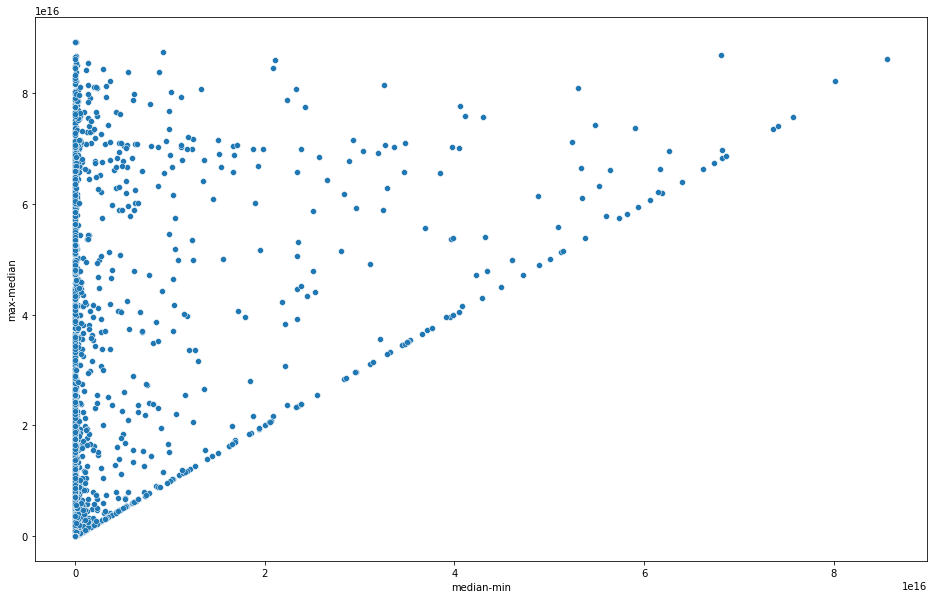

In [59]:
plt.figure(figsize = (16,10))
sns.scatterplot(data = temp, x = "median-min",y = "max-median").invert_yaxis()
plt.show()

> 중앙값과 최소값 차이가 0인경우가 많고 중간값 이후에 마지막 평가가까지 기간은 다양하다. 
즉 처음에 하루 평가를 몰아서 하고 한동안 안 하다가 하게되는 경우가 많은 것으로 보인다. 
보통 초반에 평가를 모두 끝내고 이후에는 아주 천천히 했음을 알 수 있다.

> ~가운데 경계선을 세션의 기준으로 삼으면 좋을 것 같다~

> median값으로 나누는것이 어려울 뿐더러 별로 좋은 방법도 아니었다. 한 유저가 평가한 영화중 중앙에 위치한평가의 시간을 정확히 가운데라고 보기 어렵다. 왜냐하면 1월1일에 4개를 평가하고 1월 20일에 6개를 평가한 사람은 중앙값이 1월 20일 나오기 떄문에 정확히 1월1일과 1월20일을 구분짓는세션이라고 보기 어렵다.

In [19]:
import datetime as dt
data["iddiff"] = data.diff(periods=1)["UserId"]
data["timediff"] = data.diff(periods=1)["Time"]
session = [1]
s = 1
for i, j in zip(data["iddiff"][1:], data["timediff"][1:]):
    if (i == 0)&(j < dt.timedelta(1)):  # 1일 단위로 자름
        session.append(s)
    else :
        s +=1
        session.append(s)
        continue
data["SessionId"] = session
data

,UserId,ItemId,Rating,Timestamp,Time,iddiff,timediff,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,NaN,NaT,1
22,1,1270,5,978300055,2000-12-31 22:00:55,0.0,0 days 00:00:36,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0.0,0 days 00:00:00,1
37,1,1022,5,978300055,2000-12-31 22:00:55,0.0,0 days 00:00:00,1
24,1,2340,3,978300103,2000-12-31 22:01:43,0.0,0 days 00:00:48,1
...,...,...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0.0,0 days 00:00:31,20715
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0.0,0 days 00:00:35,20715
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,0.0,0 days 00:00:00,20715
1000167,6040,161,3,997454486,2001-08-10 14:41:26,0.0,0 days 00:00:22,20715


In [ ]:
import datetime as dt
data["iddiff"] = data.diff(periods=1)["UserId"]
data["timediff"] = data.diff(periods=1)["Time"]
session = [1]
s = 1
for i, j in zip(data["iddiff"][1:], data["timediff"][1:]):
    if (i == 0)&(j < dt.timedelta(1)):  # 1일 단위로 자름
        session.append(s)
    else :
        s +=1
        session.append(s)
        continue
data["SessionId"] = session
data

__Session Length__  
너무 많은 평가를 매긴 경우 이상치일 수 있다. 

In [20]:
# UserId Lenght
session_length = data.groupby(["SessionId"]).size()  # 유저 아이디 숫자, 즉 각 유저아이디별로 활동한 사건 수
session_length

SessionId
1         40
2         13
3        129
4         51
5         21
        ... 
20712      7
20713     14
20714      1
20715     21
20716      1
Length: 20716, dtype: int64

최소 값 :  1
최대 값 :  1849
평균 값 :  48.281955976057155
중앙 값 :  7.0
누적백분율 90% 값 :  139.0


<AxesSubplot:>

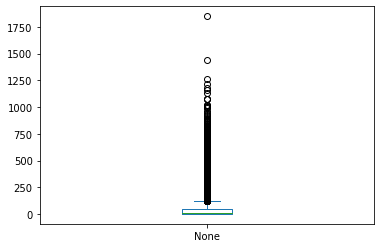

In [22]:
# 기본적인 통계값 확인
print("최소 값 : ",session_length.min())
print("최대 값 : ",session_length.max())
print("평균 값 : ",session_length.mean())
print("중앙 값 : ",session_length.median())
print("누적백분율 90% 값 : ",session_length.quantile(0.90))

session_length.plot(kind = "box")

평균도 48.28이고 상위 90% 를 뽑아도 139밖에 안된다. 

In [23]:
session_length.groupby(session_length).size()

1       5203
2       2232
3       1130
4        694
5        554
        ... 
1180       1
1216       1
1262       1
1442       1
1849       1
Length: 636, dtype: int64

In [24]:
length_count = session_length.groupby(session_length).size()  # 유저의 활동수를 기준으로 묶는다.
length_percent_cumsum = length_count.cumsum() / length_count.sum()  # 각 활동이 얼마나 많은 활동이었는지 누적 분포로 확인한다. 
length_percent_cumsum_90 = length_percent_cumsum[length_percent_cumsum < 0.9]  # 클릭수가 너무 많은 상위 90% 이상은 제거한다.
length_percent_cumsum_90

1      0.251159
2      0.358901
3      0.413449
4      0.446949
5      0.473692
         ...   
134    0.896602
135    0.897229
136    0.898339
137    0.898919
138    0.899595
Length: 138, dtype: float64

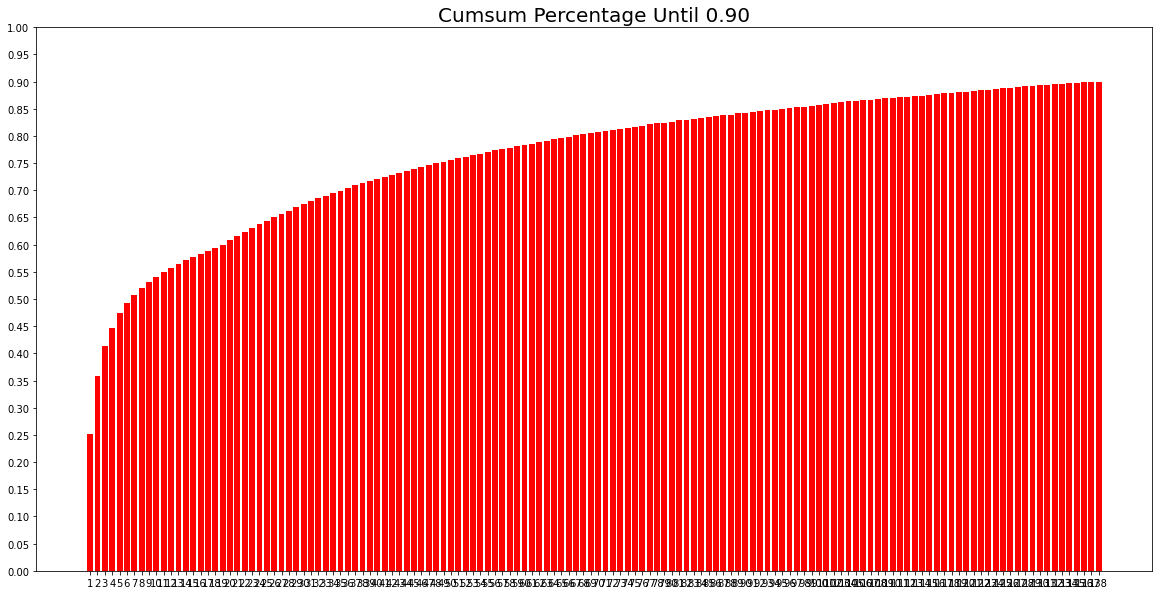

In [28]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_90.index,
        height=length_percent_cumsum_90, color='red')
plt.xticks(length_percent_cumsum_90.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.90', size=20)
# plt.xticks(rotation = 45)
plt.show()

__Session Time__  

최신 트렌드를 반영하기 위해 최근 1년간 평가한 session을 활용

In [29]:
# 가장 오래된 노드와 가장 최신 노드
oldest,latest = data["Time"].min(), data["Time"].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [30]:
# month_ago = latest - dt.timedelta(730)
# data_recent = data[data["Time"] > month_ago]
# data_recent

__Data Cleaning__

In [16]:
data.shape

(1000209, 8)

In [31]:
# Rating 이 4 미만인 행은 삭제
data = data[data["Rating"] >= 4]
data

,UserId,ItemId,Rating,Timestamp,Time,iddiff,timediff,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,NaN,NaT,1
22,1,1270,5,978300055,2000-12-31 22:00:55,0.0,0 days 00:00:36,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0.0,0 days 00:00:00,1
37,1,1022,5,978300055,2000-12-31 22:00:55,0.0,0 days 00:00:00,1
36,1,1836,5,978300172,2000-12-31 22:02:52,0.0,0 days 00:01:09,1
...,...,...,...,...,...,...,...,...
1000119,6040,3671,4,997454367,2001-08-10 14:39:27,0.0,0 days 00:00:18,20715
999923,6040,232,5,997454398,2001-08-10 14:39:58,0.0,0 days 00:00:31,20715
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0.0,0 days 00:00:31,20715
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0.0,0 days 00:00:35,20715


In [32]:
def cleanse_recursive(data : pd.DataFrame, shortest, least_eval) -> pd.DataFrame :
    while True : 
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_eval)
        after_len = len(data)
        if before_len == after_len:
            break
    return data
        
        
def cleanse_short_session(data : pd.DataFrame, shortest) : 
    session_len = data.groupby("SessionId").size()
    session_use = session_len[session_len >= shortest].index  # 가장 짧은 세션 이상의 session의 index 저장
    data = data[data["SessionId"].isin(session_use)]
    return data

def cleanse_unpopular_item(data : pd.DataFrame, least_eval) : 
    item_popular = data.groupby(["ItemId"]).size()
    item_use = item_popular[item_popular >= least_eval].index
    data = data[data["ItemId"].isin(item_use)]
    return data

In [33]:
# itemid 출현 빈토 최소값
data.groupby(["ItemId"]).size().min()

1

In [34]:
# 평가 수가 2개 이하인 세션은 삭제, 평가 횟수가 5회 미만인 영화도 삭제
data = cleanse_recursive(data, shortest = 2, least_eval = 5)
data

,UserId,ItemId,Rating,Timestamp,Time,iddiff,timediff,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,NaN,NaT,1
22,1,1270,5,978300055,2000-12-31 22:00:55,0.0,0 days 00:00:36,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0.0,0 days 00:00:00,1
37,1,1022,5,978300055,2000-12-31 22:00:55,0.0,0 days 00:00:00,1
36,1,1836,5,978300172,2000-12-31 22:02:52,0.0,0 days 00:01:09,1
...,...,...,...,...,...,...,...,...
1000118,6040,457,4,997454349,2001-08-10 14:39:09,0.0,0 days 00:02:17,20715
1000119,6040,3671,4,997454367,2001-08-10 14:39:27,0.0,0 days 00:00:18,20715
999923,6040,232,5,997454398,2001-08-10 14:39:58,0.0,0 days 00:00:31,20715
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0.0,0 days 00:00:31,20715


__Train / Valid / Test split__

In [35]:
def split_by_date(data : pd.DataFrame, n_days: int):
    final_time = data["Time"].max()
    session_last_time = data.groupby(["SessionId"])["Time"].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index
    
    before_date = data[data["SessionId"].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date    

In [36]:
dt.timedelta(600)

datetime.timedelta(days=600)

In [37]:
data.sort_values(by = "Time", ascending = True, inplace = True)

In [38]:
data["date"] = data["Time"].dt.date

In [39]:
train, test = split_by_date(data, n_days = 180)
train, val = split_by_date(train, n_days = 180)

In [40]:
train.shape, val.shape, test.shape

((559619, 9), (5740, 9), (4298, 9))

In [41]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [42]:
stats_info(train, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 559619
	 Sessions: 12160
	 Items: 3119
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-04 20:27:21

* valid Set Stats Info
	 Events: 5740
	 Sessions: 584
	 Items: 1822
	 First Time : 2002-03-04 18:58:36
	 Last Time : 2002-08-31 20:38:06

* test Set Stats Info
	 Events: 4298
	 Sessions: 409
	 Items: 1473
	 First Time : 2002-09-01 04:16:16
	 Last Time : 2003-02-28 17:49:50



In [43]:
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [44]:
save_path = data_path / 'processed'  # Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성

--------------------------------------

실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [45]:
class SessionDataset:

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId
        # 유니크 아이디 개수만큼 배열 생성
            
    def get_click_offsets(self):
        """
        세션에 수 누적값 구하기
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()  # 이게 무슨말일까?
        return offsets

In [46]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Timestamp,Time,iddiff,timediff,SessionId,date,item_idx
1000138,6040,858,4,956703932,2000-04-25 23:05:32,1.0,-1 days +08:58:23,20709,2000-04-25,0
999873,6040,593,5,956703954,2000-04-25 23:05:54,0.0,0 days 00:00:22,20709,2000-04-25,1
1000153,6040,2384,4,956703954,2000-04-25 23:05:54,0.0,0 days 00:00:00,20709,2000-04-25,2
1000192,6040,2019,5,956703977,2000-04-25 23:06:17,0.0,0 days 00:00:00,20709,2000-04-25,3
1000007,6040,1961,4,956703977,2000-04-25 23:06:17,0.0,0 days 00:00:23,20709,2000-04-25,4
999980,6040,3505,4,956704056,2000-04-25 23:07:36,0.0,0 days 00:00:00,20709,2000-04-25,5
999967,6040,3111,5,956704056,2000-04-25 23:07:36,0.0,0 days 00:00:00,20709,2000-04-25,6
999920,6040,213,5,956704056,2000-04-25 23:07:36,0.0,0 days 00:00:00,20709,2000-04-25,7
999868,6040,573,4,956704056,2000-04-25 23:07:36,0.0,0 days 00:01:19,20709,2000-04-25,8
999888,6040,919,5,956704191,2000-04-25 23:09:51,0.0,0 days 00:00:00,20709,2000-04-25,9


In [47]:
# sessionId to idx
train_dataset.session_idx

array([    0,     1,     2, ..., 12157, 12158, 12159])

In [48]:
# 이게 무슨 의미일까?
# train_dataset.click_offsets
train_dataset.df.groupby("SessionId").size()

SessionId
1        34
2        11
3        73
4        37
5        18
         ..
20710    60
20711    29
20712     5
20713    10
20715    17
Length: 12160, dtype: int64

In [49]:
# 1번 session에 2번 session을 더해서 점점 누적
# 그래서 그게 무슨 의미가 있을까?
train_dataset.df.groupby("SessionId").size().cumsum()[1:]  # 심지어 2번 인덱스 부터 시작

SessionId
2            45
3           118
4           155
5           173
6           255
          ...  
20710    559558
20711    559587
20712    559592
20713    559602
20715    559619
Length: 12159, dtype: int64

In [50]:
# 0 부터 시작하는 sessioid 발생건수의 누적합 배열이 생성된다.
train_dataset.click_offsets

array([     0,     34,     45, ..., 559592, 559602, 559619], dtype=int32)

__SessionDataLoader__

In [51]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [52]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Timestamp,Time,iddiff,timediff,SessionId,date,item_idx
1000138,6040,858,4,956703932,2000-04-25 23:05:32,1.0,-1 days +08:58:23,20709,2000-04-25,0
999873,6040,593,5,956703954,2000-04-25 23:05:54,0.0,0 days 00:00:22,20709,2000-04-25,1
1000153,6040,2384,4,956703954,2000-04-25 23:05:54,0.0,0 days 00:00:00,20709,2000-04-25,2
1000192,6040,2019,5,956703977,2000-04-25 23:06:17,0.0,0 days 00:00:00,20709,2000-04-25,3
1000007,6040,1961,4,956703977,2000-04-25 23:06:17,0.0,0 days 00:00:23,20709,2000-04-25,4
999980,6040,3505,4,956704056,2000-04-25 23:07:36,0.0,0 days 00:00:00,20709,2000-04-25,5
999967,6040,3111,5,956704056,2000-04-25 23:07:36,0.0,0 days 00:00:00,20709,2000-04-25,6
999920,6040,213,5,956704056,2000-04-25 23:07:36,0.0,0 days 00:00:00,20709,2000-04-25,7
999868,6040,573,4,956704056,2000-04-25 23:07:36,0.0,0 days 00:01:19,20709,2000-04-25,8
999888,6040,919,5,956704191,2000-04-25 23:09:51,0.0,0 days 00:00:00,20709,2000-04-25,9


In [53]:
iter_ex = iter(train_data_loader)

In [54]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  34  45 116]
Label Item Idx are :       [  1  35  46 117]
Previous Masked Input Idx are []


### Step 3. 모델 구성

------------------------------------

이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

__Evaluation Metric__

In [55]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

__Model Architecture__

In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [57]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [59]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [60]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3119)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    475650    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3119)               159069    
Total params: 634,719
Trainable params: 634,719
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습

-----------------------------

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [61]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

__model_1__  

train, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20

In [62]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

Evaluation:  48%|████▊     | 19/40 [00:12<00:14,  1.49it/s]


	 - Recall@20 epoch 1: 0.068668
	 - MRR@20    epoch 1: 0.016164



Evaluation:  48%|████▊     | 19/40 [00:12<00:13,  1.51it/s]


	 - Recall@20 epoch 2: 0.104852
	 - MRR@20    epoch 2: 0.021992



Evaluation:  48%|████▊     | 19/40 [00:12<00:14,  1.50it/s]


	 - Recall@20 epoch 3: 0.118832
	 - MRR@20    epoch 3: 0.025553



Evaluation:  48%|████▊     | 19/40 [00:12<00:13,  1.52it/s]


	 - Recall@20 epoch 4: 0.127878
	 - MRR@20    epoch 4: 0.027993



Evaluation:  48%|████▊     | 19/40 [00:12<00:13,  1.56it/s]


	 - Recall@20 epoch 5: 0.131168
	 - MRR@20    epoch 5: 0.029833



Evaluation:  48%|████▊     | 19/40 [00:12<00:13,  1.56it/s]


	 - Recall@20 epoch 6: 0.129523
	 - MRR@20    epoch 6: 0.031214



Evaluation:  48%|████▊     | 19/40 [00:12<00:13,  1.58it/s]


	 - Recall@20 epoch 7: 0.130345
	 - MRR@20    epoch 7: 0.031072



Evaluation:  48%|████▊     | 19/40 [00:12<00:13,  1.57it/s]


	 - Recall@20 epoch 8: 0.129112
	 - MRR@20    epoch 8: 0.030762



Evaluation:  48%|████▊     | 19/40 [00:12<00:13,  1.55it/s]


	 - Recall@20 epoch 9: 0.128289
	 - MRR@20    epoch 9: 0.030775



Evaluation:  48%|████▊     | 19/40 [00:11<00:13,  1.58it/s]

	 - Recall@20 epoch 10: 0.128289
	 - MRR@20    epoch 10: 0.031379



> val 인덱싱에서 문제가 있었는데 날짜를 늘리니까 갑자기 됐다.
아무래도 길이가 너무 짧아서 문제가 있었던거 같다. 

### Step 5. 모델 테스트

-------------------------

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [63]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [64]:
test_model(model, args, test)

Evaluation:  40%|████      | 12/30 [00:07<00:11,  1.57it/s]

	 - Recall@20: 0.145833
	 - MRR@20: 0.034613



### Step 6. 하이퍼 파라미터 수정

__model_2__

train, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20

In [65]:
args = Args(train, val, test, batch_size=128, hsz=100, drop_rate=0.1, lr=0.001, epochs=20, k=40)
model_2 = create_model(args)
train_model(model_2, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3119)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  966300    
_________________________________________________________________
dropout_1 (Dropout)          (128, 100)                0         
_________________________________________________________________
dense_1 (Dense)              (128, 3119)               315019    
Total params: 1,281,319
Trainable params: 1,281,319
Non-trainable params: 0
_________________________________________________________________


Evaluation:  48%|████▊     | 19/40 [00:22<00:24,  1.17s/it]


	 - Recall@40 epoch 1: 0.136924
	 - MRR@40    epoch 1: 0.023085



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.13s/it]


	 - Recall@40 epoch 2: 0.177220
	 - MRR@40    epoch 2: 0.027966



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.12s/it]


	 - Recall@40 epoch 3: 0.188322
	 - MRR@40    epoch 3: 0.032370



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.11s/it]


	 - Recall@40 epoch 4: 0.192434
	 - MRR@40    epoch 4: 0.032770



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.12s/it]


	 - Recall@40 epoch 5: 0.197368
	 - MRR@40    epoch 5: 0.033782



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.11s/it]


	 - Recall@40 epoch 6: 0.194079
	 - MRR@40    epoch 6: 0.034737



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.12s/it]


	 - Recall@40 epoch 7: 0.194079
	 - MRR@40    epoch 7: 0.034676



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.11s/it]


	 - Recall@40 epoch 8: 0.190378
	 - MRR@40    epoch 8: 0.034163



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.12s/it]


	 - Recall@40 epoch 9: 0.187911
	 - MRR@40    epoch 9: 0.033959



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.12s/it]


	 - Recall@40 epoch 10: 0.183388
	 - MRR@40    epoch 10: 0.033477



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.11s/it]


	 - Recall@40 epoch 11: 0.180510
	 - MRR@40    epoch 11: 0.032724



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.13s/it]


	 - Recall@40 epoch 12: 0.180099
	 - MRR@40    epoch 12: 0.033591



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.12s/it]


	 - Recall@40 epoch 13: 0.178865
	 - MRR@40    epoch 13: 0.033475



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.12s/it]


	 - Recall@40 epoch 14: 0.181743
	 - MRR@40    epoch 14: 0.033884



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.12s/it]


	 - Recall@40 epoch 15: 0.182155
	 - MRR@40    epoch 15: 0.032326



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.12s/it]


	 - Recall@40 epoch 16: 0.181332
	 - MRR@40    epoch 16: 0.032873



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.14s/it]


	 - Recall@40 epoch 17: 0.180921
	 - MRR@40    epoch 17: 0.031798



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.12s/it]


	 - Recall@40 epoch 18: 0.183799
	 - MRR@40    epoch 18: 0.031022



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.11s/it]


	 - Recall@40 epoch 19: 0.182977
	 - MRR@40    epoch 19: 0.031641



Evaluation:  48%|████▊     | 19/40 [00:21<00:23,  1.12s/it]

	 - Recall@40 epoch 20: 0.182155
	 - MRR@40    epoch 20: 0.030889



In [66]:
test_model(model_2, args, test)

Evaluation:  40%|████      | 12/30 [00:07<00:11,  1.55it/s]

	 - Recall@40: 0.130859
	 - MRR@40: 0.030491



## 회고 
> 두 번째 파일인 "[Exp_16]Project_MovielensSBR_nosession.ipynb"파일에 회고하겠습니다. 